Initial dataset shape: (1005167, 5)
Initial dataset preview:
   product_number         department_desc  discount date_of_order  orders
0               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-01       0
1               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-02       0
2               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-03       5
3               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-04       0
4               0  MENS OWN BRAND BOTTOMS       0.0    2022-01-05       0
Dataset shape after removing duplicates: (1005167, 5)

Rows with Missing Dates (retained for now):
Empty DataFrame
Columns: [product_number, department_desc, discount, date_of_order, orders]
Index: []
Dataset shape after handling missing dates: (1005167, 5)

Handling Missing Values...
Remaining missing values after imputation:
product_number     0
department_desc    0
discount           0
date_of_order      0
orders             0
dtype: int64

Removing outliers for 'orders' and 'discount'..

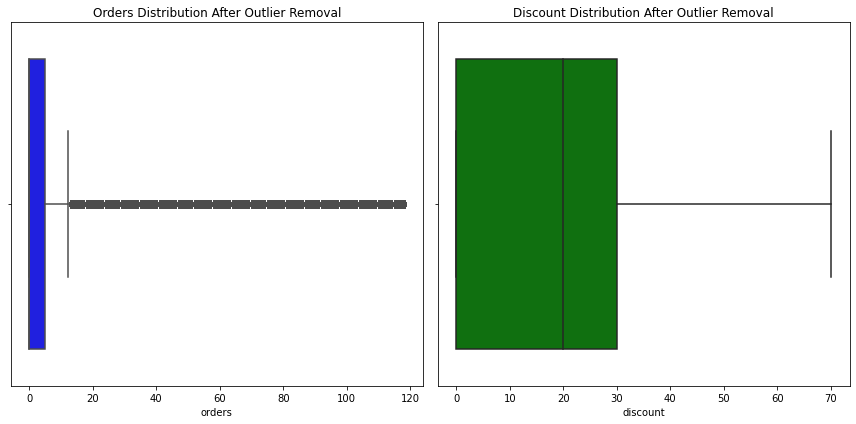

Upper Value Dataset Shape: (931006, 5)
Lower Value Dataset Shape: (931006, 5)
Upper discount data saved to: upper_discount_data.csv
Lower discount data saved to: lower_discount_data.csv


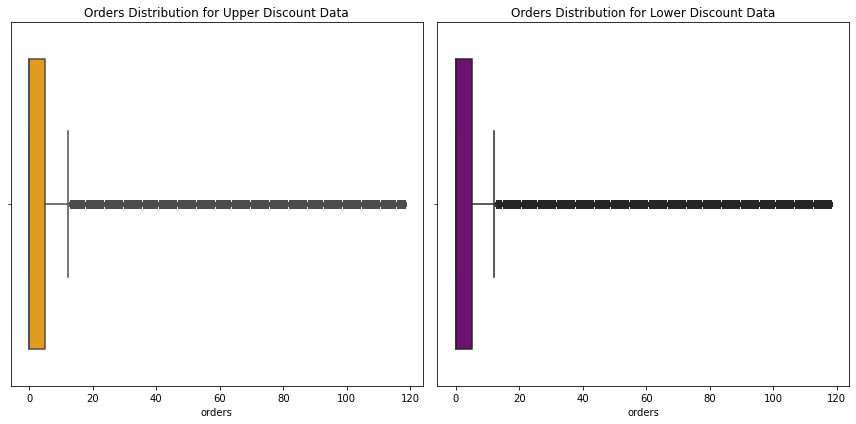

Data preprocessing completed successfully!


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '2022_orders_discount_data.csv'  # Replace with your file path
data_cleaned = pd.read_csv(file_path)
print(f"Initial dataset shape: {data_cleaned.shape}")
print(f"Initial dataset preview:\n{data_cleaned.head()}")

# 1. Remove Duplicates
data_cleaned.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {data_cleaned.shape}")

# 2. Handle Missing Dates
# Convert `date_of_order` to datetime and set format explicitly to 'YYYY-MM-DD'
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# Identify and print rows with missing dates
missing_date_rows = data_cleaned[data_cleaned['date_of_order'].isnull()]
print("\nRows with Missing Dates (retained for now):")
print(missing_date_rows)

# Replace missing dates with the earliest available date
data_cleaned['date_of_order'] = data_cleaned['date_of_order'].fillna(data_cleaned['date_of_order'].min())
print(f"Dataset shape after handling missing dates: {data_cleaned.shape}")

# 3. Handle Missing Values
print("\nHandling Missing Values...")

# Impute missing values for 'department_desc' with 'Unknown'
data_cleaned['department_desc'] = data_cleaned['department_desc'].fillna('Unknown')

# Impute missing values for 'discount' and 'orders' with their respective medians
data_cleaned['discount'] = data_cleaned['discount'].fillna(data_cleaned['discount'].median())
data_cleaned['orders'] = data_cleaned['orders'].fillna(data_cleaned['orders'].median())

# Verify remaining missing values
print(f"Remaining missing values after imputation:\n{data_cleaned.isnull().sum()}")

# 4. Define Outlier Removal Function
def remove_outliers_percentile(df, column, lower_percentile=1, upper_percentile=99):
    """
    Removes outliers from the specified column in the dataframe based on percentiles.
    Parameters:
        - df: pandas DataFrame
        - column: str, the column to check for outliers
        - lower_percentile: float, lower percentile threshold (e.g., 1 for 1st percentile)
        - upper_percentile: float, upper percentile threshold (e.g., 99 for 99th percentile)
    Returns:
        - Cleaned DataFrame with outliers removed.
    """
    lower_bound = np.percentile(df[column], lower_percentile)
    upper_bound = np.percentile(df[column], upper_percentile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 5. Remove Outliers
print("\nRemoving outliers for 'orders' and 'discount'...")
data_cleaned = remove_outliers_percentile(data_cleaned, column='orders', lower_percentile=1, upper_percentile=99)
data_cleaned = remove_outliers_percentile(data_cleaned, column='discount', lower_percentile=1, upper_percentile=99)
print(f"Dataset shape after removing outliers: {data_cleaned.shape}")

# Verify dataset statistics
print(f"\nDataset statistics after outlier removal:\n{data_cleaned[['orders', 'discount']].describe()}")

# Box plots after outlier removal
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=data_cleaned['orders'], color='blue')
plt.title('Orders Distribution After Outlier Removal')

plt.subplot(1, 2, 2)
sns.boxplot(x=data_cleaned['discount'], color='green')
plt.title('Discount Distribution After Outlier Removal')
plt.tight_layout()
plt.show()

# 6. Separate into Upper and Lower CSV Files
# Group by product and date, extract rows with max and min discounts
grouped_data = data_cleaned.groupby(['product_number', 'date_of_order'])
upper_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmax()]).reset_index(drop=True)
lower_value_data = grouped_data.apply(lambda x: x.loc[x['discount'].idxmin()]).reset_index(drop=True)

print(f"Upper Value Dataset Shape: {upper_value_data.shape}")
print(f"Lower Value Dataset Shape: {lower_value_data.shape}")

# Save the results to CSV files
upper_csv_path = 'upper_discount_data.csv'
lower_csv_path = 'lower_discount_data.csv'
upper_value_data.to_csv(upper_csv_path, index=False)
lower_value_data.to_csv(lower_csv_path, index=False)

print(f"Upper discount data saved to: {upper_csv_path}")
print(f"Lower discount data saved to: {lower_csv_path}")

# Visualize distributions of orders and discounts for upper and lower datasets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=upper_value_data['orders'], color='orange')
plt.title('Orders Distribution for Upper Discount Data')

plt.subplot(1, 2, 2)
sns.boxplot(x=lower_value_data['orders'], color='purple')
plt.title('Orders Distribution for Lower Discount Data')

plt.tight_layout()
plt.show()

print("Data preprocessing completed successfully!")



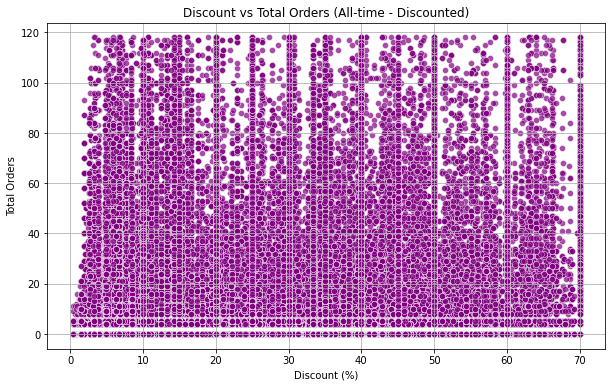

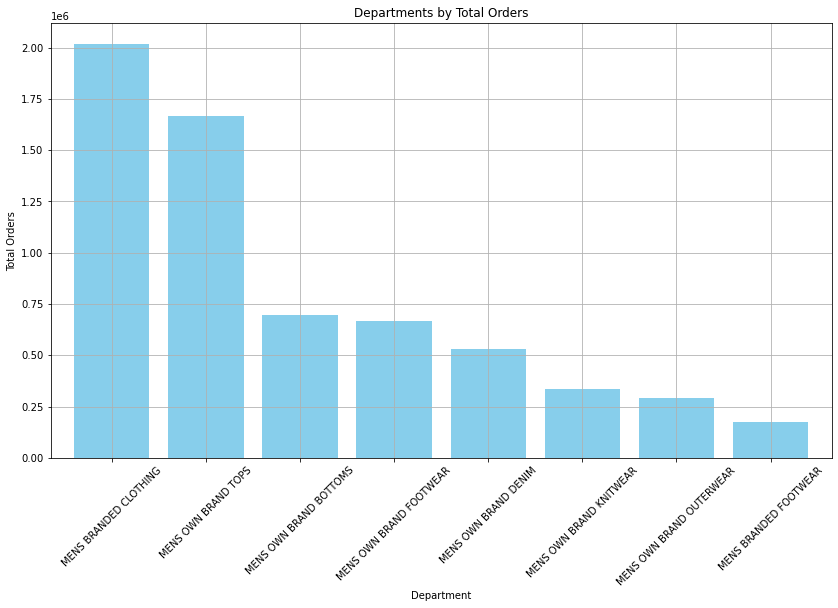

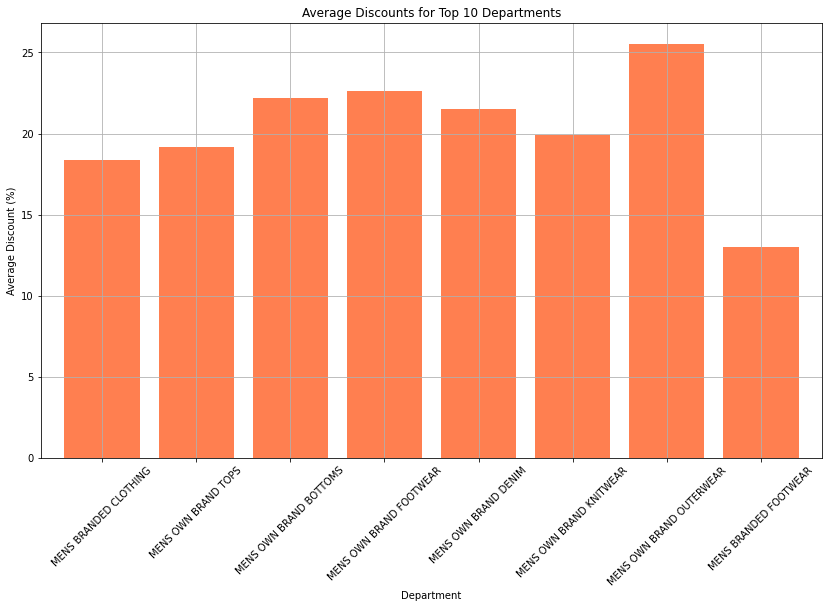

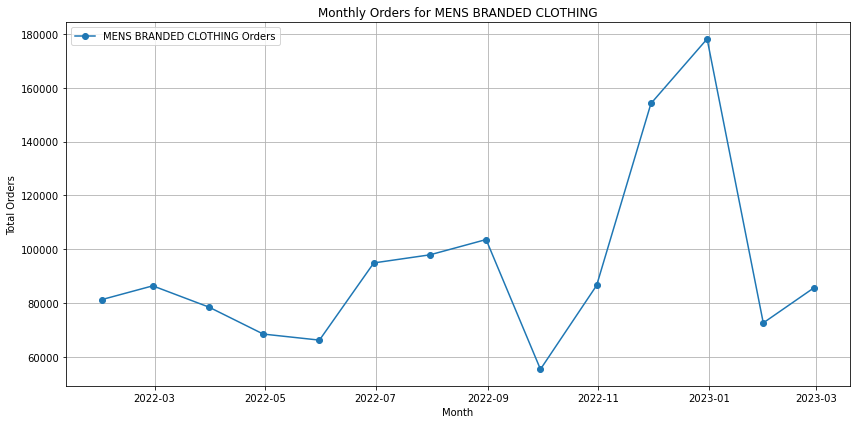

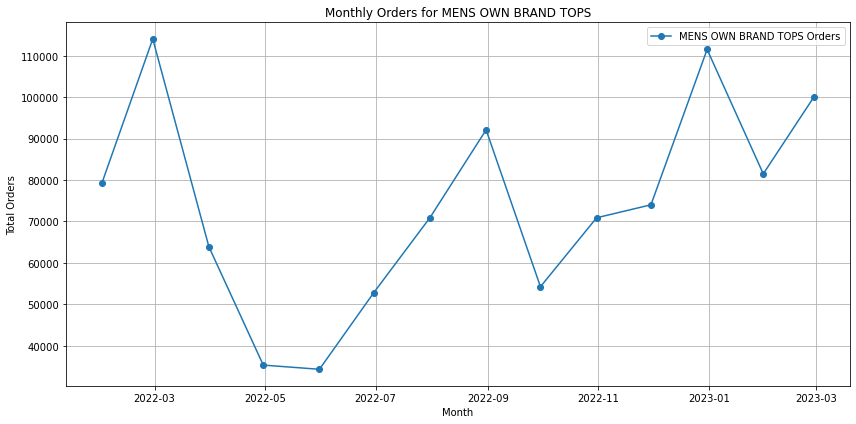

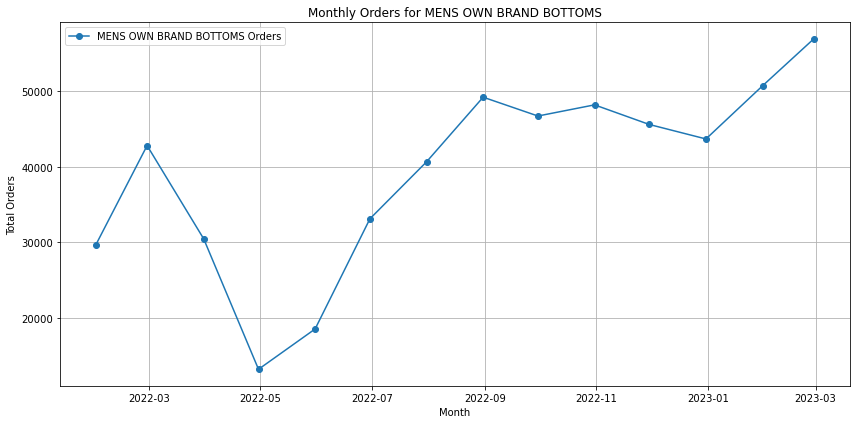

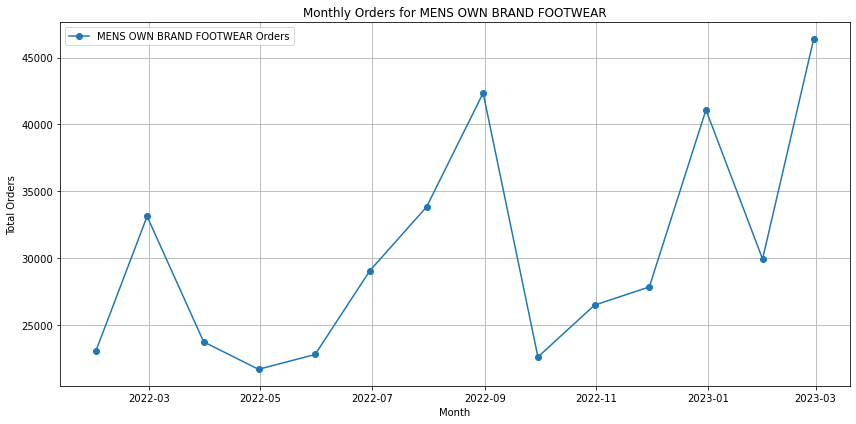

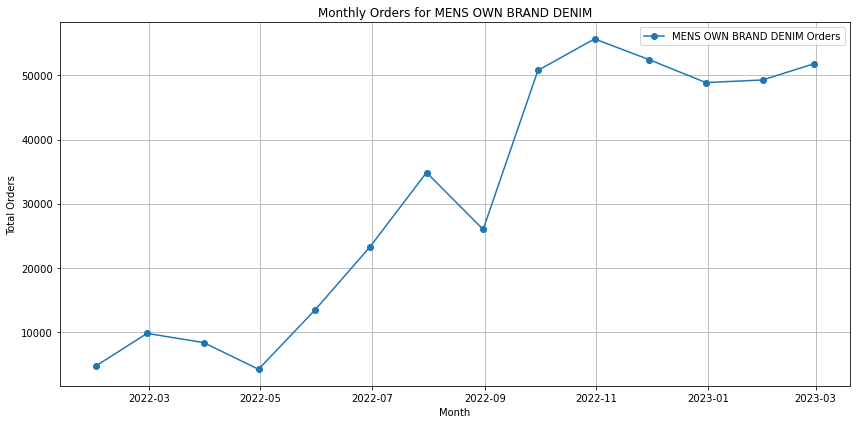

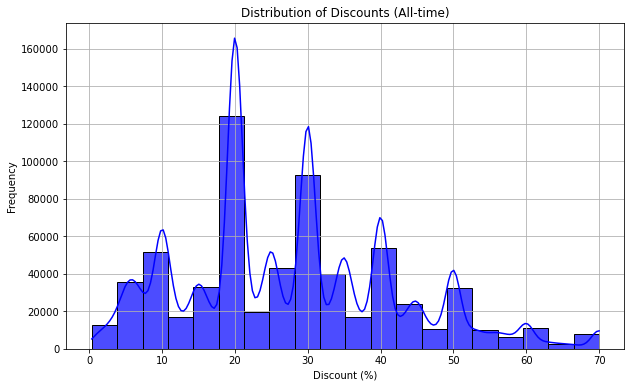

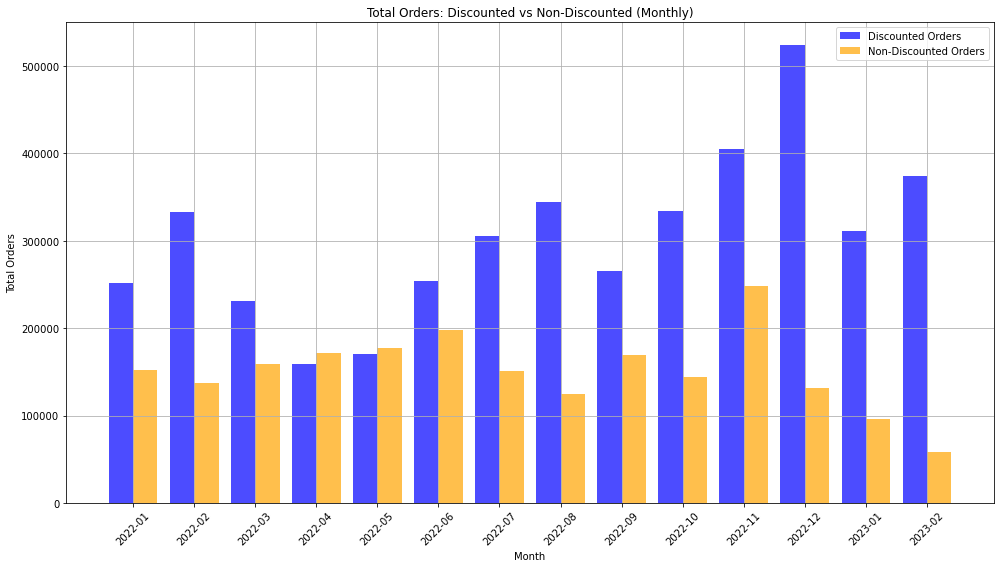

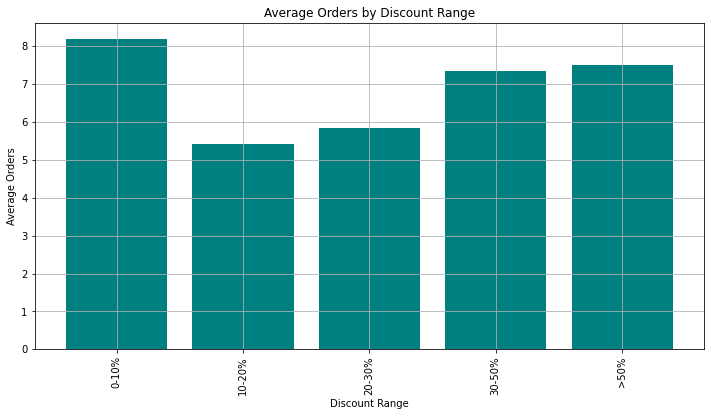

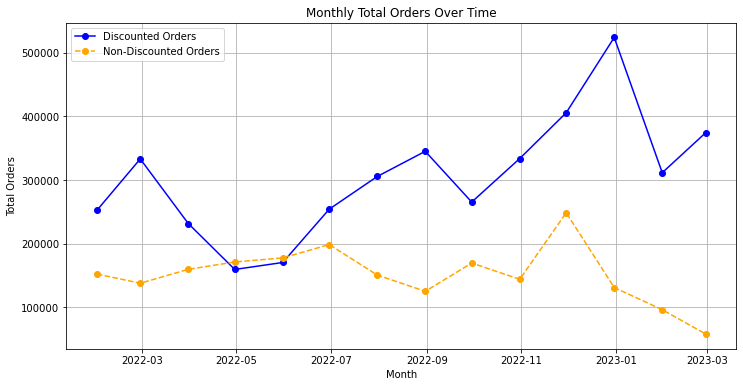

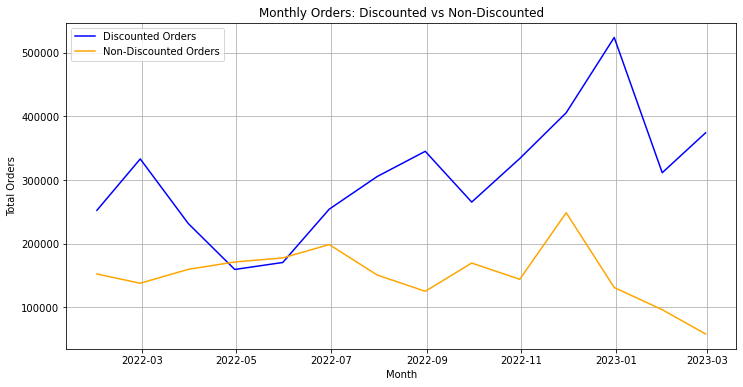

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned data
file_path = 'upper_discount_data.csv'
data_cleaned = pd.read_csv(file_path)

# Ensure the date column is datetime
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])

# Validate discount segregation
if not all(data_cleaned['discount'] >= 0):
    raise ValueError("Discount column contains negative values, which are invalid.")

# Separate discounted and non-discounted data
discounted_data = data_cleaned[data_cleaned['discount'] > 0]
non_discounted_data = data_cleaned[data_cleaned['discount'] == 0]

# Aggregate data monthly for discounted and non-discounted separately
discounted_monthly = discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()

non_discounted_monthly = non_discounted_data.resample('M', on='date_of_order').agg({
    'orders': 'sum'
}).reset_index()

# Merge the two datasets for analysis
monthly_data = pd.merge(
    discounted_monthly,
    non_discounted_monthly,
    on='date_of_order',
    how='outer',
    suffixes=('_discounted', '_non_discounted')
)

# Replace NaN with 0 to handle months without any orders for a specific category
monthly_data.fillna(0, inplace=True)

# Add discount range for analysis (for discounted data only)
bins = [0, 10, 20, 30, 50, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-50%', '>50%']
if 'discount_discounted' in monthly_data.columns:
    monthly_data['discount_range'] = pd.cut(monthly_data['discount_discounted'], bins=bins, labels=labels)

### 1. Discount vs Orders Scatter Plot (All-time Aggregation)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=discounted_data, alpha=0.7, color="purple")
plt.title('Discount vs Total Orders (All-time - Discounted)')
plt.xlabel('Discount (%)')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()

### 2. Top Departments by Total Orders (Granular Analysis)
dept_aggregated = data_cleaned.groupby('department_desc').agg({
    'orders': 'sum',
    'discount': 'mean'
}).sort_values(by='orders', ascending=False)

# Top 10 Departments by Total Orders
plt.figure(figsize=(14, 8))
dept_aggregated['orders'].head(10).plot(kind='bar', color='skyblue', width=0.8)
plt.title('Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Average Discounts for Top 10 Departments
plt.figure(figsize=(14, 8))
dept_aggregated['discount'].head(10).plot(kind='bar', color='coral', width=0.8)
plt.title('Average Discounts for Top 10 Departments')
plt.xlabel('Department')
plt.ylabel('Average Discount (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 3. Monthly Department-Level Analysis
top_departments = dept_aggregated.head(5).index

# For each department, plot monthly discounted orders
for department in top_departments:
    dept_data = discounted_data[discounted_data['department_desc'] == department]
    dept_monthly = dept_data.resample('M', on='date_of_order').agg({
        'orders': 'sum',
        'discount': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(dept_monthly['date_of_order'], dept_monthly['orders'], marker='o', label=f'{department} Orders')
    plt.title(f'Monthly Orders for {department}')
    plt.xlabel('Month')
    plt.ylabel('Total Orders')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 4. Distribution of Discounts (Granular)
plt.figure(figsize=(10, 6))
sns.histplot(discounted_data['discount'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Discounts (All-time)')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 5. Discounted vs Non-Discounted Sales (Monthly)
plt.figure(figsize=(14, 8))
x_positions = np.arange(len(monthly_data['date_of_order']))
plt.bar(
    x_positions - 0.2,
    monthly_data['orders_discounted'],
    width=0.4,
    label='Discounted Orders',
    color='blue',
    alpha=0.7
)
plt.bar(
    x_positions + 0.2,
    monthly_data['orders_non_discounted'],
    width=0.4,
    label='Non-Discounted Orders',
    color='orange',
    alpha=0.7
)
plt.xticks(x_positions, monthly_data['date_of_order'].dt.strftime('%Y-%m'), rotation=45)
plt.title('Total Orders: Discounted vs Non-Discounted (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Average Orders by Discount Range
avg_orders_by_discount = discounted_data.groupby(pd.cut(discounted_data['discount'], bins=bins, labels=labels))['orders'].mean()

plt.figure(figsize=(12, 6))
avg_orders_by_discount.plot(kind='bar', color='teal', width=0.8)
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.grid(True)
plt.show()

### 7. Monthly Total Orders Over Time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['date_of_order'], monthly_data['orders_discounted'], marker='o', color='blue', label='Discounted Orders')
plt.plot(monthly_data['date_of_order'], monthly_data['orders_non_discounted'], marker='o', linestyle='--', color='orange', label='Non-Discounted Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()

### 8. Monthly Orders: Discounted vs Non-Discounted (Granular Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_of_order', y='orders_discounted', data=monthly_data, label='Discounted Orders', color='blue')
sns.lineplot(x='date_of_order', y='orders_non_discounted', data=monthly_data, label='Non-Discounted Orders', color='orange')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.show()




--- Descriptive Statistics ---
             orders      discount
count  53872.000000  53872.000000
mean      16.897572     22.893577
std       18.936334     18.901356
min        4.000000      0.000000
25%        5.000000      5.410000
50%       10.000000     20.050000
75%       21.000000     37.140000
max      118.000000     70.000000

--- Normality Tests for Orders ---
Shapiro-Wilk Test - Statistic: 0.6942, P-value: 0.0000
Orders are not normally distributed.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 53872.
  res = hypotest_fun_out(*samples, **kwds)


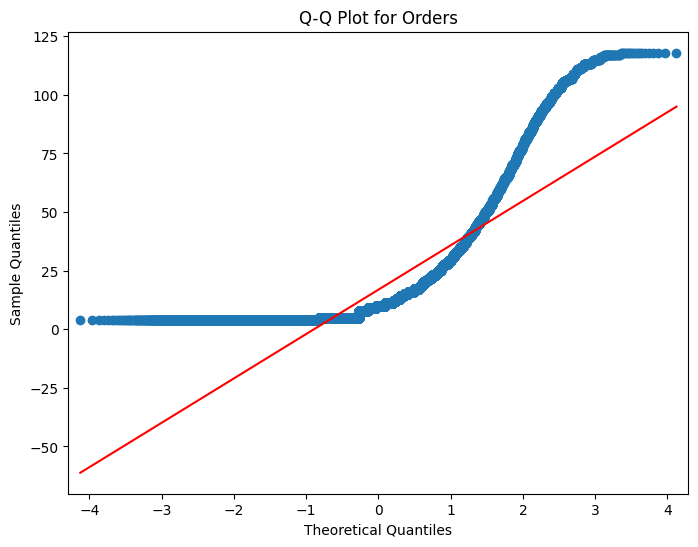


--- Correlation Analysis ---
Pearson Correlation Matrix:
            orders  discount
orders    1.000000 -0.008894
discount -0.008894  1.000000
Spearman Correlation (Orders vs Discount): -0.0218, P-value: 0.0000


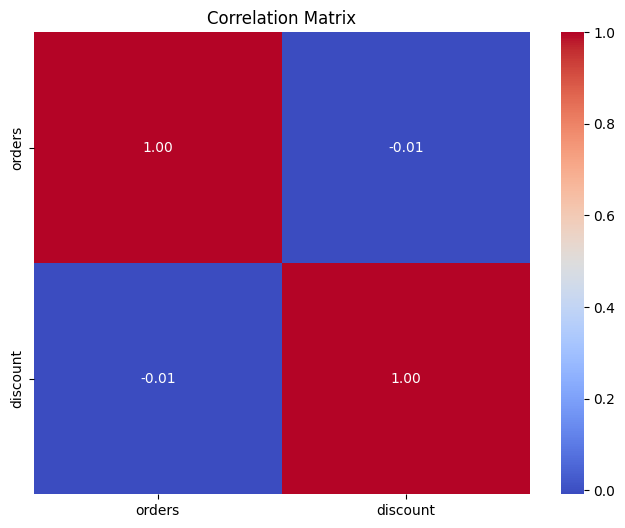


--- Hypothesis Testing: Effect of Discounts on Orders ---
T-statistic: -8.8605, P-value: 0.0000
Reject H0: Discounts significantly influence orders.

--- Chi-Square Test: Independence Between High Orders and High Discounts ---
Chi-Square Statistic: 54.7164, P-value: 0.0000
Significant relationship between high orders and high discounts.

--- ANOVA: Orders Across Seasons ---
T-statistic: -7.2911, P-value: 0.0000
Significant differences in orders between summer and Christmas seasons.

--- Clustering Analysis: Orders and Discounts ---


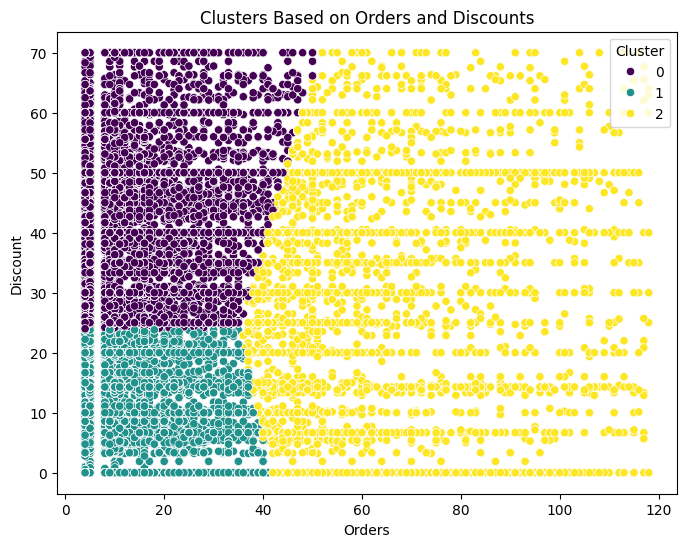

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency, shapiro, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# Load Data
file_path = 'filtered_upper_discount_data.csv'
data = pd.read_csv(file_path)
data['date_of_order'] = pd.to_datetime(data['date_of_order'])

# Drop invalid data
data = data[data['orders'] > 0]
data.dropna(inplace=True)

# --- Descriptive Statistics ---
print("\n--- Descriptive Statistics ---")
print(data[['orders', 'discount']].describe())

# --- Normality Test ---
print("\n--- Normality Tests for Orders ---")
shapiro_stat, shapiro_p = shapiro(data['orders'])
print(f"Shapiro-Wilk Test - Statistic: {shapiro_stat:.4f}, P-value: {shapiro_p:.4f}")
if shapiro_p < 0.05:
    print("Orders are not normally distributed.")
else:
    print("Orders are normally distributed.")

# Q-Q Plot for Orders
plt.figure(figsize=(8, 6))
qqplot(data['orders'], line='s', ax=plt.gca())
plt.title('Q-Q Plot for Orders')
plt.show()

# --- Correlation Analysis ---
print("\n--- Correlation Analysis ---")
correlation_matrix = data[['orders', 'discount']].corr()
spearman_corr, spearman_p = spearmanr(data['orders'], data['discount'])
print("Pearson Correlation Matrix:")
print(correlation_matrix)
print(f"Spearman Correlation (Orders vs Discount): {spearman_corr:.4f}, P-value: {spearman_p:.4f}")

# Heatmap of Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# --- Hypothesis Testing ---
print("\n--- Hypothesis Testing: Effect of Discounts on Orders ---")
discounted = data[data['discount'] > 0]['orders']
non_discounted = data[data['discount'] == 0]['orders']
t_stat, p_val = ttest_ind(discounted, non_discounted, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Reject H0: Discounts significantly influence orders.")
else:
    print("Fail to Reject H0: No significant effect of discounts on orders.")

# --- Chi-Square Test ---
print("\n--- Chi-Square Test: Independence Between High Orders and High Discounts ---")
data['high_orders'] = (data['orders'] > data['orders'].median()).astype(int)
data['high_discounts'] = (data['discount'] > data['discount'].median()).astype(int)
contingency_table = pd.crosstab(data['high_orders'], data['high_discounts'])
chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2_stat:.4f}, P-value: {chi2_p:.4f}")
if chi2_p < 0.05:
    print("Significant relationship between high orders and high discounts.")
else:
    print("No significant relationship between high orders and high discounts.")

# --- ANOVA Test ---
print("\n--- ANOVA: Orders Across Seasons ---")
data['is_summer'] = data['date_of_order'].dt.month.isin([6, 7, 8]).astype(int)
data['is_christmas'] = (data['date_of_order'].dt.month == 12).astype(int)
anova_result = ttest_ind(data[data['is_summer'] == 1]['orders'], data[data['is_christmas'] == 1]['orders'])
print(f"T-statistic: {anova_result.statistic:.4f}, P-value: {anova_result.pvalue:.4f}")
if anova_result.pvalue < 0.05:
    print("Significant differences in orders between summer and Christmas seasons.")
else:
    print("No significant differences in orders between summer and Christmas seasons.")

# --- Clustering Analysis ---
print("\n--- Clustering Analysis: Orders and Discounts ---")
from sklearn.cluster import KMeans

X_cluster = data[['orders', 'discount']].dropna()
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_cluster)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='orders', y='discount', hue='Cluster', palette='viridis')
plt.title('Clusters Based on Orders and Discounts')
plt.xlabel('Orders')
plt.ylabel('Discount')
plt.legend(title='Cluster')
plt.show()




Dataset loaded successfully.
Date column converted to datetime and week period added.
Data aggregated to weekly level.
Zero discounts replaced with a small value.
Percentage changes calculated and clipped.
Elasticity calculated with error handling.
Product-level elasticity analysis saved to 'product_elasticity_analysis.csv'.
Department-level elasticity analysis saved to 'department_elasticity_analysis.csv'.


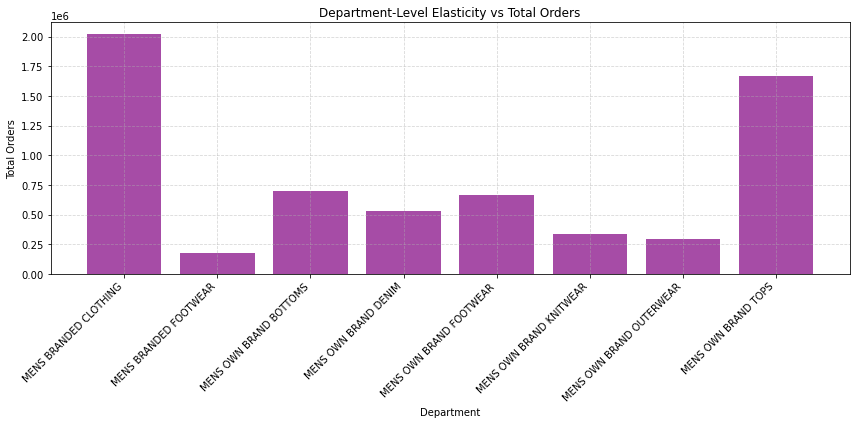

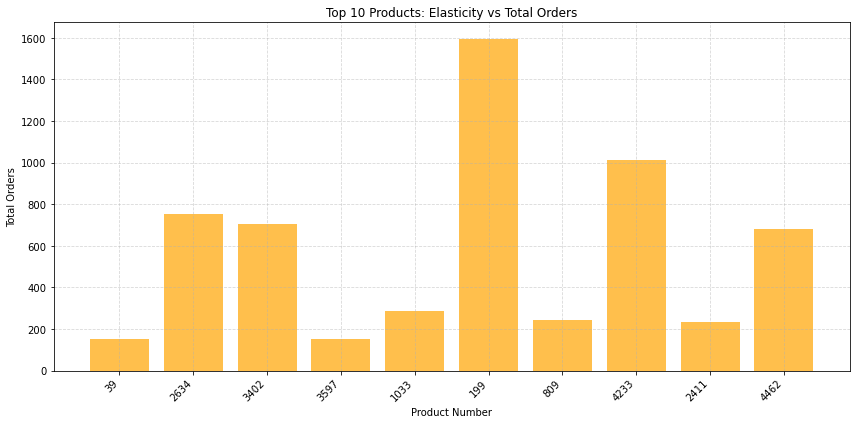

Elastic products data saved to 'elastic_products_data.csv'.


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
file_path = 'upper_discount_data.csv'  # Replace with your file path
data_cleaned = pd.read_csv(file_path)
print("Dataset loaded successfully.")

# Step 2: Convert Date Column to Datetime and Add Week Period
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])
data_cleaned['week'] = data_cleaned['date_of_order'].dt.to_period('W')  # Weekly periods
print("Date column converted to datetime and week period added.")

# Step 3: Aggregate Data at the Weekly Level
weekly_data = data_cleaned.groupby(['week', 'department_desc', 'product_number']).agg({
    'orders': 'sum',  # Total orders in the week
    'discount': 'mean',  # Average discount in the week
}).reset_index()
print("Data aggregated to weekly level.")

# Step 4: Handle Zero Discounts to Avoid Division Errors
weekly_data['discount'] = weekly_data['discount'].replace(0, 1e-6)
print("Zero discounts replaced with a small value.")

# Step 5: Calculate Percentage Changes for Orders and Discounts
weekly_data['pct_change_discount'] = (
    weekly_data.groupby('product_number')['discount'].pct_change().clip(lower=-1, upper=1)
)
weekly_data['pct_change_orders'] = (
    weekly_data.groupby('product_number')['orders'].pct_change().clip(lower=-1, upper=1)
)
print("Percentage changes calculated and clipped.")

# Step 6: Calculate Elasticity
weekly_data['elasticity'] = (
    weekly_data['pct_change_orders'] / weekly_data['pct_change_discount']
).replace([np.inf, -np.inf], np.nan).fillna(0)
print("Elasticity calculated with error handling.")

# Save Elasticity at the Product Level
product_elasticity = weekly_data.groupby(['product_number', 'department_desc']).agg({
    'elasticity': 'mean',
    'orders': 'sum',
    'discount': 'mean'
}).reset_index()
product_elasticity.rename(columns={
    'elasticity': 'avg_elasticity',
    'orders': 'total_orders',
    'discount': 'avg_discount'
}, inplace=True)

product_elasticity.to_csv('product_elasticity_analysis.csv', index=False)
print("Product-level elasticity analysis saved to 'product_elasticity_analysis.csv'.")

# Calculate Elasticity at the Department Level
department_elasticity = product_elasticity.groupby('department_desc').agg({
    'avg_elasticity': 'mean',
    'total_orders': 'sum',
    'avg_discount': 'mean'
}).reset_index()
department_elasticity.rename(columns={
    'avg_elasticity': 'department_avg_elasticity',
    'total_orders': 'department_total_orders',
    'avg_discount': 'department_avg_discount'
}, inplace=True)

department_elasticity.to_csv('department_elasticity_analysis.csv', index=False)
print("Department-level elasticity analysis saved to 'department_elasticity_analysis.csv'.")

# Visualizations
# Department-Level Elasticity vs Total Orders
plt.figure(figsize=(12, 6))
plt.bar(
    department_elasticity['department_desc'],
    department_elasticity['department_total_orders'],
    color='purple', alpha=0.7
)
plt.xticks(rotation=45, ha='right')
plt.title('Department-Level Elasticity vs Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Top Products by Elasticity
top_10_products = product_elasticity.sort_values(by='avg_elasticity', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.bar(
    top_10_products['product_number'].astype(str),
    top_10_products['total_orders'],
    color='orange', alpha=0.7
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products: Elasticity vs Total Orders')
plt.xlabel('Product Number')
plt.ylabel('Total Orders')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Filter Elastic Products
elastic_products = product_elasticity[product_elasticity['avg_elasticity'] > 1]
elastic_products.to_csv('elastic_products_data.csv', index=False)
print("Elastic products data saved to 'elastic_products_data.csv'.")



In [46]:
import pandas as pd

# Step 1: Load the Original Dataset and Elastic Products Data
original_file_path = 'upper_discount_data.csv'  # Replace with your file path
elastic_products_file_path = 'elastic_products_data.csv'  # Replace with your file path

original_data = pd.read_csv(original_file_path)
elastic_products = pd.read_csv(elastic_products_file_path)

print("Datasets loaded successfully.")

# Step 2: Ensure 'product_number' is unique in the elastic products data
unique_elastic_products = elastic_products['product_number'].unique()
print(f"Number of unique elastic products: {len(unique_elastic_products)}")

# Step 3: Filter Rows in Original Dataset Based on Unique Elastic Products
filtered_data = original_data[original_data['product_number'].isin(unique_elastic_products)]

# Step 4: Save the Filtered Dataset
filtered_file_path = 'filtered_upper_discount_data.csv'
filtered_data.to_csv(filtered_file_path, index=False)

print(f"Filtered data saved to '{filtered_file_path}'.")
print(f"Filtered dataset shape: {filtered_data.shape}")


Datasets loaded successfully.
Number of unique elastic products: 580
Filtered data saved to 'filtered_upper_discount_data.csv'.
Filtered dataset shape: (120922, 5)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns

# Load Filtered Dataset
file_path = 'filtered_upper_discount_data.csv'  # File containing only elastic products
data = pd.read_csv(file_path)
print("Filtered dataset loaded successfully.")

# Statistical Analysis - Summary Statistics
print("--- Summary Statistics ---")
summary_stats = data.describe()
print(summary_stats)

# Normality Test - Orders
from scipy.stats import shapiro
stat, p = shapiro(data['orders'])
print("\n--- Normality Test ---")
print(f"Shapiro-Wilk Test - Statistic: {stat:.4f}, P-value: {p:.4f}")
if p < 0.05:
    print("Orders are not normally distributed.")
else:
    print("Orders are normally distributed.")

# QQ Plot for Orders
plt.figure(figsize=(8, 6))
qqplot(data['orders'], line='s')
plt.title("Q-Q Plot for Orders")
plt.show()

# Correlation Analysis
print("\n--- Correlation Analysis ---")
correlation_matrix = data[['orders', 'discount']].corr()
print("Pearson Correlation Matrix:")
print(correlation_matrix)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Hypothesis Testing - Effect of Discounts on Orders
high_discount = data[data['discount'] > data['discount'].median()]
low_discount = data[data['discount'] <= data['discount'].median()]
t_stat, p_val = ttest_ind(high_discount['orders'], low_discount['orders'], equal_var=False)
print("\n--- Hypothesis Testing: Effect of Discounts on Orders ---")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Reject H0: Discounts significantly influence orders.")
else:
    print("Fail to reject H0: No significant effect of discounts on orders.")

# Chi-Square Test - Independence Between High Orders and High Discounts
data['high_orders'] = data['orders'] > data['orders'].median()
data['high_discounts'] = data['discount'] > data['discount'].median()
contingency_table = pd.crosstab(data['high_orders'], data['high_discounts'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print("\n--- Chi-Square Test: Independence Between High Orders and High Discounts ---")
print(f"Chi-Square Statistic: {chi2:.4f}, P-value: {p:.4f}")
if p < 0.05:
    print("Significant relationship between high orders and high discounts.")
else:
    print("No significant relationship between high orders and high discounts.")

# ANOVA - Orders Across Seasons
data['season'] = data['date_of_order'].apply(lambda x: 'Summer' if int(x.split('-')[1]) in [6, 7, 8] else
                                             ('Winter' if int(x.split('-')[1]) in [12, 1, 2] else 'Other'))
groups = [data[data['season'] == season]['orders'] for season in ['Summer', 'Winter', 'Other']]
f_stat, p_val = f_oneway(*groups)
print("\n--- ANOVA: Orders Across Seasons ---")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Significant differences in orders across seasons.")
else:
    print("No significant differences in orders across seasons.")

# Clustering Analysis - Orders and Discounts
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['orders', 'discount']])
print("\n--- Clustering Analysis: Orders and Discounts ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='orders', y='discount', hue='cluster', data=data, palette='viridis')
plt.title("Clusters Based on Orders and Discounts")
plt.show()


Dataset loaded successfully.
Training Linear Regression...
Linear Regression - R²: 0.5367, RMSE: 12.5165, MAE: 7.2370
Training Lasso Regression...
Lasso Regression - R²: 0.5348, RMSE: 12.5422, MAE: 7.2449
Training ElasticNet...
ElasticNet - R²: 0.5351, RMSE: 12.5381, MAE: 7.2435
Training Random Forest...
Random Forest - R²: 0.6603, RMSE: 10.7178, MAE: 6.5000
Training Gradient Boosting...
Gradient Boosting - R²: 0.6876, RMSE: 10.2782, MAE: 6.2746
Training Improved SARIMA...
ADF Statistic: -3.759565996972574, p-value: 0.003349183214973718


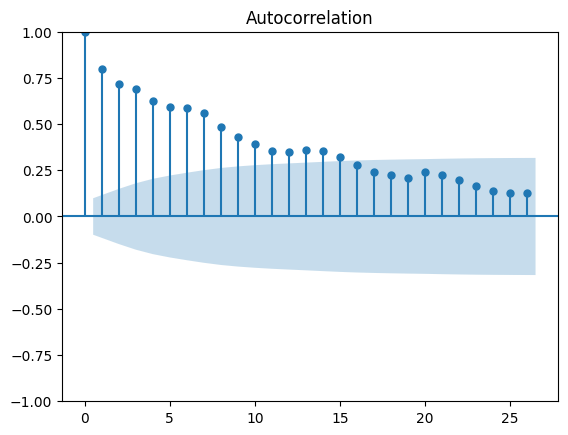

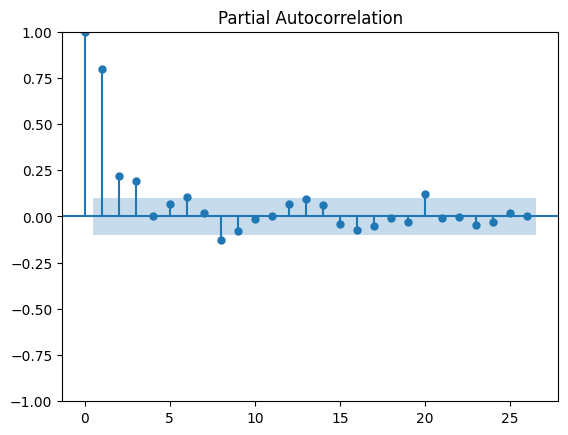

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA - R²: -2.0088, RMSE: 512.7661, MAE: 436.2351


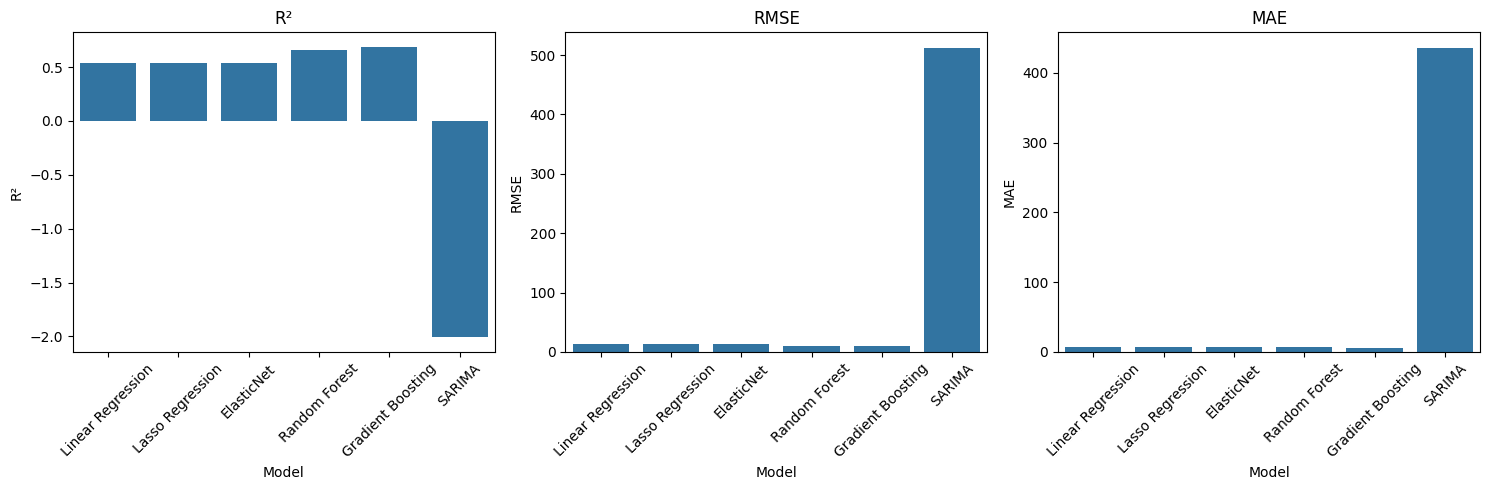

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from math import log1p, expm1
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load Data
file_path = 'filtered_upper_discount_data.csv'  # Update path
data = pd.read_csv(file_path)
data['date_of_order'] = pd.to_datetime(data['date_of_order'])
print("Dataset loaded successfully.")

# Basic Data Cleaning
data = data.dropna(subset=['orders', 'discount'])  # Drop rows with missing target or predictors
data = data[data['orders'] > 0]  # Remove rows with zero or negative orders to avoid issues with log transformation

# Feature Engineering
data['month'] = data['date_of_order'].dt.month
data['day_of_week'] = data['date_of_order'].dt.dayofweek
data['week_of_year'] = data['date_of_order'].dt.isocalendar().week
data['day_of_month'] = data['date_of_order'].dt.day
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['is_christmas'] = data['month'].apply(lambda x: 1 if x == 12 else 0)
data['is_summer'] = data['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)

# Interaction Features
data['discount_x_month'] = data['discount'] * data['month']
data['discount_x_day_of_week'] = data['discount'] * data['day_of_week']

# Rolling Features
data['rolling_orders_7'] = data['orders'].rolling(window=7, min_periods=1).mean()
data['rolling_discount_7'] = data['discount'].rolling(window=7, min_periods=1).mean()

# Lag Features
for lag in [1, 7, 14]:
    data[f'lag_orders_{lag}'] = data['orders'].shift(lag)
    data[f'lag_discount_{lag}'] = data['discount'].shift(lag)

data.dropna(inplace=True)  # Drop rows with NaN values after creating lag features

# Log Transform Target Variable
data['log_orders'] = data['orders'].apply(lambda x: log1p(x))

# Encode Categorical Variables
data = pd.get_dummies(data, columns=['department_desc'], drop_first=True)

# Define Features and Target
features = [
    'discount', 'month', 'day_of_week', 'week_of_year', 'day_of_month', 'is_weekend',
    'is_christmas', 'is_summer', 'discount_x_month', 'discount_x_day_of_week',
    'rolling_orders_7', 'rolling_discount_7', 'lag_orders_1', 'lag_orders_7', 'lag_orders_14',
    'lag_discount_1', 'lag_discount_7', 'lag_discount_14'
] + [col for col in data.columns if col.startswith('department_desc')]

X = data[features]
y = data['log_orders']

# Power Transformation for Better Normality
transformer = PowerTransformer()
X = pd.DataFrame(transformer.fit_transform(X), columns=features)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.8),
    'Random Forest': RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42),
}

# Train and Evaluate Models
results = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_transformed = np.expm1(y_pred)
    y_test_transformed = np.expm1(y_test)

    r2 = r2_score(y_test_transformed, y_pred_transformed)
    rmse = np.sqrt(mean_squared_error(y_test_transformed, y_pred_transformed))
    mae = mean_absolute_error(y_test_transformed, y_pred_transformed)

    results.append({'Model': name, 'R²': r2, 'RMSE': rmse, 'MAE': mae})
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Time-Series Analysis with Improved SARIMA
print("Training Improved SARIMA...")
time_series_data = data.groupby('date_of_order')['orders'].sum()

# Check Stationarity
adf_test = adfuller(time_series_data)
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    # Differencing to achieve stationarity
    time_series_data = time_series_data.diff().dropna()

# Split Time Series into Training and Testing
train_ts = time_series_data[:-30]  # Use all except the last 30 days for training
test_ts = time_series_data[-30:]  # Use the last 30 days for testing

# Plot ACF/PACF for Parameter Selection
plot_acf(train_ts)
plot_pacf(train_ts)
plt.show()

# Improved SARIMA Modeling
sarima_model = SARIMAX(train_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit(disp=False)

# Forecasting
sarima_forecast = sarima_result.forecast(steps=len(test_ts))

# Evaluate SARIMA Model
sarima_r2 = r2_score(test_ts, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test_ts, sarima_forecast))
sarima_mae = mean_absolute_error(test_ts, sarima_forecast)

results.append({'Model': 'SARIMA', 'R²': sarima_r2, 'RMSE': sarima_rmse, 'MAE': sarima_mae})
print(f"SARIMA - R²: {sarima_r2:.4f}, RMSE: {sarima_rmse:.4f}, MAE: {sarima_mae:.4f}")

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv('model_performance_updated.csv', index=False)

# Visualize Metrics
plt.figure(figsize=(15, 5))
metrics = ['R²', 'RMSE', 'MAE']
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
